In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('./mhDataset.csv', index_col=0)

In [ ]:
df.dropna(inplace = True)

In [ ]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df['original_statement'].str.lower()

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)

In [ ]:
lemmatizer=WordNetLemmatizer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(token,pos="v") for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

In [ ]:
# Get the English stopword set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a space-separated string
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

# Apply the function to the 'tokens_stemmed' column
df['tokens_stemmed'] = df['tokens_stemmed'].apply(remove_stopwords)

In [ ]:
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [ ]:
from collections import Counter

class_counts = {
    'Depression':15404,
    'Normal': 16343,
    'Anxiety': 3841,
    'Bipolar': 2777,
    'Stress': 2587,
    'Personality disorder': 1077
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count)
    for cls, count in class_counts.items()
}

print(class_weights)

{'Depression': 0.4547411927637843, 'Normal': 0.42861367761936814, 'Anxiety': 1.8237004252364835, 'Bipolar': 2.5224462849597886, 'Stress': 2.707705192629816, 'Personality disorder': 6.504023522129372}


In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
# Calculate sample weights based on the class_weights dictionary and the resampled training labels
sample_weights = np.array([class_weights[lbl_enc.inverse_transform([label])[0]] for label in y_train_resampled])

In [ ]:
# Define your models
models = {

    'Naive Bayes': BernoulliNB(), # BernoulliNB is suitable for binary or multi-label text classification
}



For Naive Bayes
Accuracy: 0.742326909350464
                      precision    recall  f1-score   support

             Anxiety       0.69      0.60      0.64       790
             Bipolar       0.75      0.66      0.70       543
          Depression       0.90      0.65      0.75      3014
              Normal       0.71      0.94      0.81      3313
Personality disorder       0.80      0.33      0.47       232
              Stress       0.45      0.54      0.49       514

            accuracy                           0.74      8406
           macro avg       0.72      0.62      0.64      8406
        weighted avg       0.77      0.74      0.74      8406



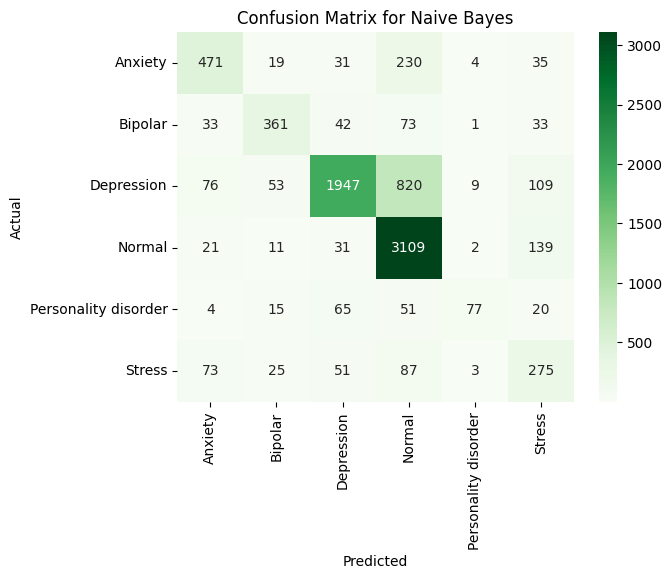

In [ ]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the models dictionary
for name, clf in models.items():
    # Fit the model with the calculated sample weights
    clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

Best parameters: {'alpha': 0.01}
Best cross-validation accuracy: 0.8539268355078026

Accuracy on the test set with best parameters: 0.7665952890792291
                      precision    recall  f1-score   support

             Anxiety       0.73      0.61      0.66       790
             Bipolar       0.78      0.58      0.67       543
          Depression       0.79      0.77      0.78      3014
              Normal       0.77      0.93      0.84      3313
Personality disorder       0.96      0.28      0.43       232
              Stress       0.56      0.32      0.41       514

            accuracy                           0.77      8406
           macro avg       0.76      0.58      0.63      8406
        weighted avg       0.76      0.77      0.75      8406



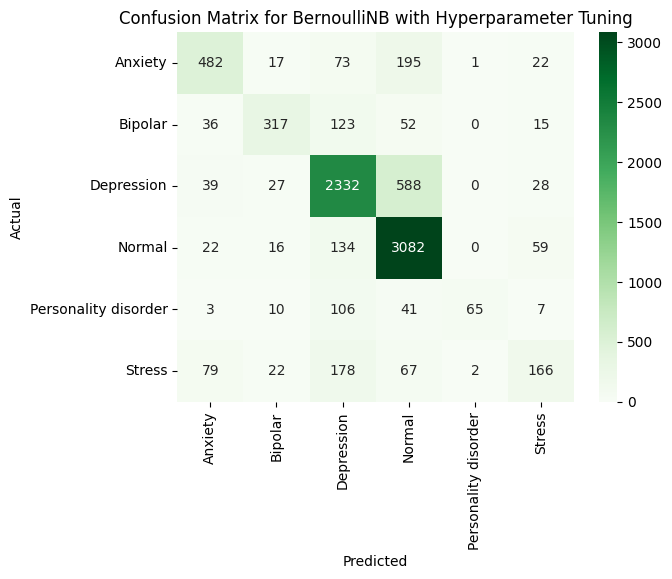

In [ ]:
# Define the parameter grid for BernoulliNB
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

# Initialize GridSearchCV with the BernoulliNB model and parameter grid
grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search on the resampled training data with sample weights
grid_search.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate the model with the best parameters on the test set
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print("\nAccuracy on the test set with best parameters:", accuracy)

# Compute and plot the confusion matrix for the best model
labels = lbl_enc.classes_
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BernoulliNB with Hyperparameter Tuning')
plt.show()

In [ ]:
# Get input from the user
user_input = input("Please enter the statement you want to classify: ")

# Create a pandas DataFrame for the user input to apply the same preprocessing steps
user_df = pd.DataFrame({'original_statement': [user_input]})

# Calculate numerical features for the user input
user_df['num_of_characters'] = user_df['original_statement'].str.len()
user_df['num_of_sentences'] = user_df['original_statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Apply the same text preprocessing steps as used for training
user_df['statement'] = user_df['original_statement'].str.lower()
user_df['statement'] = user_df['statement'].apply(remove_patterns)
user_df['tokens'] = user_df['statement'].apply(word_tokenize)
user_df['tokens_stemmed'] = user_df['tokens'].apply(stem_tokens)
user_df['tokens_stemmed'] = user_df['tokens_stemmed'].apply(remove_stopwords)

# Vectorize the stemmed tokens using the fitted TF-IDF vectorizer
user_tfidf = vectorizer.transform(user_df['tokens_stemmed'])

# Extract numerical features for the user input
user_num = user_df[['num_of_characters', 'num_of_sentences']].values

# Combine TF-IDF features with numerical features
user_combined = hstack([user_tfidf, user_num])

# Predict the class using the best trained model
predicted_label_index = best_clf.predict(user_combined)[0]

# Inverse transform the predicted label index to the original class name
predicted_label = lbl_enc.inverse_transform([predicted_label_index])[0]

print(f"\nThe predicted status for the statement is: {predicted_label}")

Please enter the statement you want to classify: I keep getting chest tightness and stomach cramps, but the doctor says I’m fine.

The predicted status for the statement is: Anxiety


In [ ]:
import pickle

# Define the filenames for the pickled objects
model_filename = 'best_bernoulli_nb_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'
label_encoder_filename = 'label_encoder.pkl'

# Pickle the trained model
with open(model_filename, 'wb') as f:
    pickle.dump(best_clf, f)

# Pickle the TF-IDF vectorizer
with open(vectorizer_filename, 'wb') as f:
    pickle.dump(vectorizer, f)

# Pickle the label encoder
with open(label_encoder_filename, 'wb') as f:
    pickle.dump(lbl_enc, f)

print(f"Model saved to {model_filename}")
print(f"Vectorizer saved to {vectorizer_filename}")
print(f"Label encoder saved to {label_encoder_filename}")

Model saved to best_bernoulli_nb_model.pkl
Vectorizer saved to tfidf_vectorizer.pkl
Label encoder saved to label_encoder.pkl
